In [1]:
import pandas as pd
import numpy as np
import scipy.optimize
import scipy.stats
import seaborn as sns
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from collections import Counter


In [2]:
listings = pd.read_csv("test_data/listings_shorted.csv", sep=",")
sigVars = ['GUID','REGISTRATION_YEAR', 'MILEAGE', 'POWER_IN_KW', 'HORSEPOWER', 'GEARING_TYPE',
       'WARRANTY',
       'PRICE_PUBLIC', 'CYLINDERS', 'EMISSION_CLASS', 'PRIMARY_FUEL_TYPE',
       'CONSUMPTION_HIGHWAY', 'CONSUMPTION_CITY', 'CONSUMPTION_MIXED',
       'ELECTRIC_CONSUMPTION_MIXED', 'EFFICIENCY_CLASS', 'CO2_EMISSION', 'EMISSION_STICKER']
listings_processed = listings[sigVars]
numericVars = ['MILEAGE','POWER_IN_KW', 'HORSEPOWER',
       'PRICE_PUBLIC',
       'CYLINDERS',
       'CONSUMPTION_HIGHWAY', 'CONSUMPTION_CITY', 'CONSUMPTION_MIXED',
       'CO2_EMISSION']
listings_numeric = listings[numericVars]
n_std = 2
for col in listings_numeric.columns:
    mean = listings_numeric[col].mean()
    sd = listings_numeric[col].std()
    listings_numeric = listings_numeric[listings_numeric[col] <= mean+(n_std*sd)]

In [3]:
print(listings_numeric)

     MILEAGE  POWER_IN_KW  HORSEPOWER  PRICE_PUBLIC  CYLINDERS  \
1     156000          125         170         16000        4.0   
2      19531          101         137         18450        3.0   
4      85520          103         140          7990        4.0   
5      30160          151         205         21489        4.0   
6     125000           77         105          6290        4.0   
..       ...          ...         ...           ...        ...   
424    11909          110         150         30400        4.0   
426   120000          110         150         16000        4.0   
427    90120           85         116          7990        4.0   
429   133000           80         109         10900        4.0   
430    49000           59          80          5000        4.0   

     CONSUMPTION_HIGHWAY  CONSUMPTION_CITY  CONSUMPTION_MIXED  CO2_EMISSION  
1                    5.6               7.3                6.2         163.0  
2                    4.3               6.2         

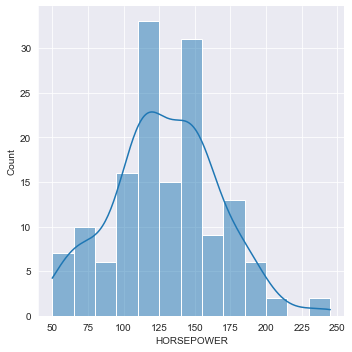

In [4]:
sns.displot(listings_numeric['HORSEPOWER'], kde = True, stat = 'count')

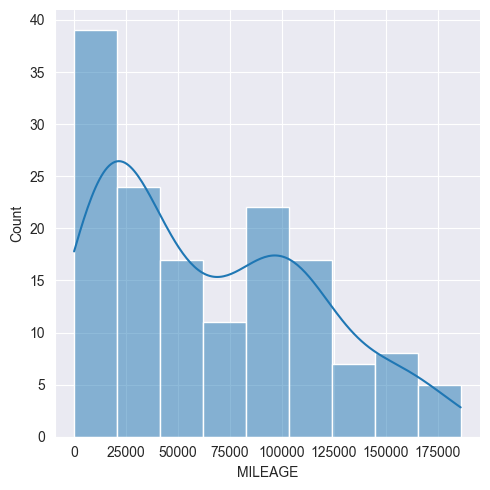

In [5]:
sns.displot(listings_numeric['MILEAGE'], kde = True, stat = 'count')

245.0
200


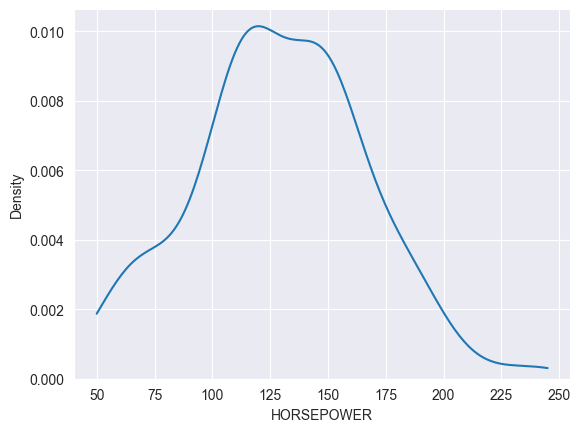

In [6]:
# x,y = sns.distplot(listings_numeric['HORSEPOWER'], hist=False).get_lines()[0].get_data()
x,y = sns.kdeplot(listings_numeric['HORSEPOWER'], cut=0).get_lines()[0].get_data()
#density = sns.kdeplot(listings_numeric['HORSEPOWER']).get_lines()[0]
#print(type(density))
print(np.max(x))
print(len(y))

200
186000.0


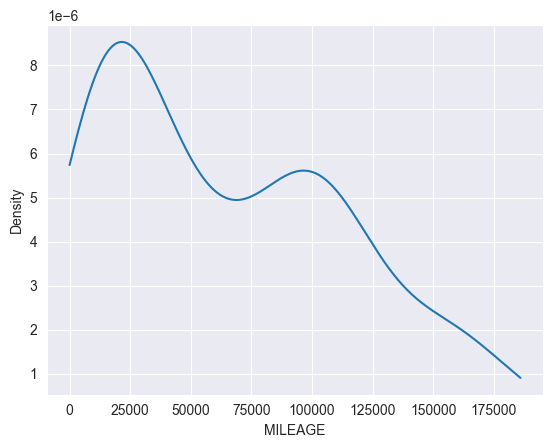

In [7]:
x_m,y_m = sns.kdeplot(listings_numeric['MILEAGE'], cut=0).get_lines()[0].get_data()
print(len(x_m))
print(np.max(x_m))

In [8]:
def PolyCoefficients(x, coeffs):
    """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.
        The coefficients must be in ascending order (``x**0`` to ``x**o``).
    """

    o = len(coeffs)
    rev_coeffs = coeffs[::-1]
    print(f'# This is a polynomial of order {o}.')
    y = 0
    for i in range(o):
        y += rev_coeffs[i] * x ** i

    return y

# This is a polynomial of order 16.


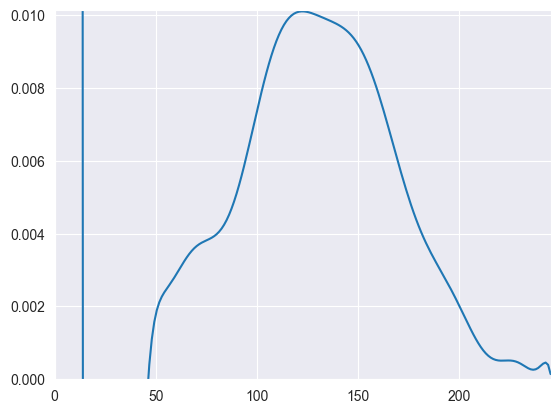

In [26]:
coeffs10 = np.polyfit(x,y, 15)
fx = np.linspace(0,np.max(x),len(x))
function = PolyCoefficients(fx, coeffs10)

plt.xlim(0, np.max(x))
plt.ylim(0, np.max(y))
plt.plot(fx, function)
plt.show()


# This is a polynomial of order 11.


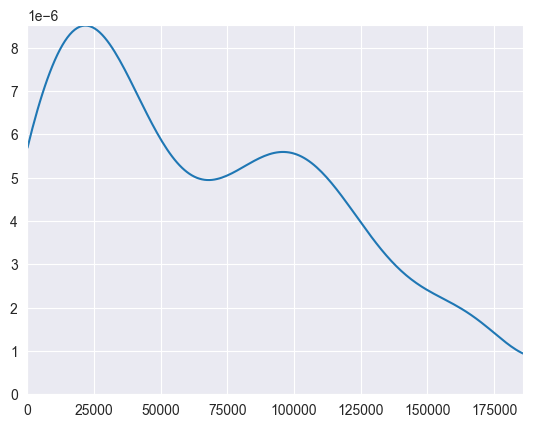

In [27]:
coeffs_m = np.polyfit(x_m,y_m, 10)
fx_m = np.linspace(0,np.max(x_m),len(x_m))
function_m = PolyCoefficients(fx_m, coeffs_m)
plt.xlim(0, np.max(x_m))
plt.ylim(0, np.max(y_m))
plt.plot(fx_m, function_m)
plt.show()

In [32]:
def plot_comparison(apprx_function, density_x, density_y):
    """ Takes in the approximated functionand plots it against the extracted density.
    """
    fx = np.linspace(0, np.max(density_x), len(density_x))

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharex='all')
    fig.suptitle('Comparison of density and approximation.')
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')


    # plot the function
    plt.subplot(1, 2, 1)
    #plt.xlim(0, np.max(density_x))
    #plt.ylim(0, np.max(density_y))
    plt.plot(fx, density_y, 'r.-')
    plt.ylabel('Density')

    plt.subplot(1, 2, 2)
    plt.plot(fx, apprx_function, 'ko-')
    plt.ylabel('Approximation')

    plt.tight_layout()
    plt.show()


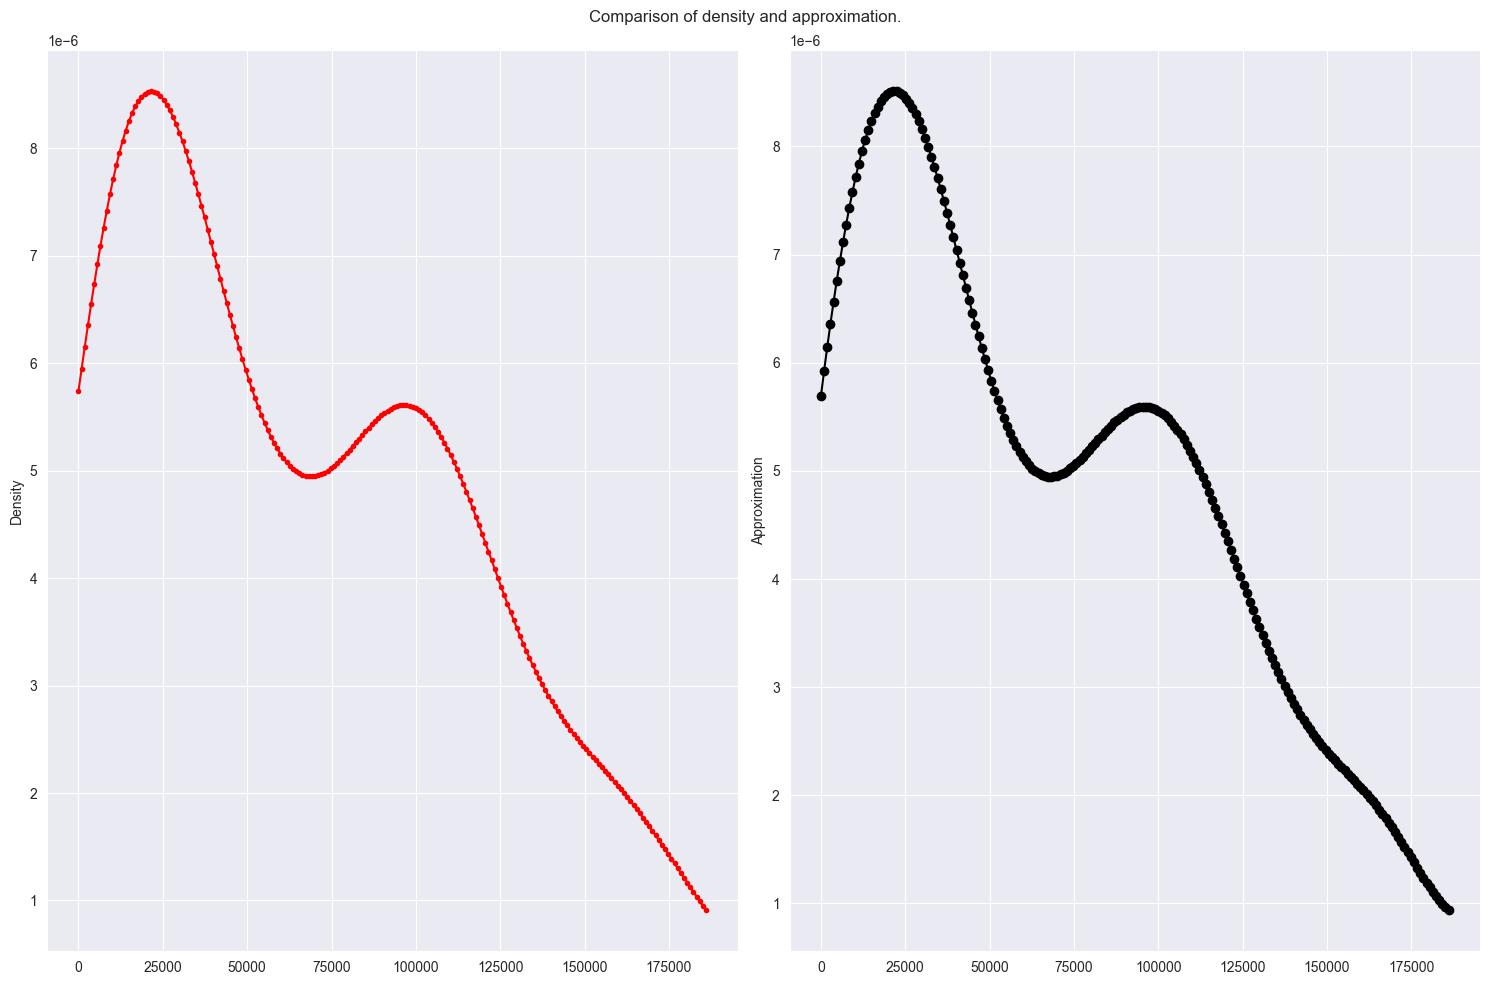

In [34]:
plot_comparison(function_m, x_m, y_m)

In [36]:
perc = np.percentile(x_m, 60)
median = np.median(x_m)
print(perc)
print(median)

111609.99999999999
93012.5


In [43]:
scale = [1,2,3,4,5,6,7,8,9,10]
#scale = scale[::-1]
mapping = map(lambda perc : np.percentile(x_m, perc * 10), scale)
# print(list(mapping))
scoring = list(mapping)[::-1]
print(scoring)

[186000.0, 167402.49999999997, 148805.0, 130207.49999999997, 111609.99999999999, 93012.5, 74415.0, 55817.49999999999, 37220.00000000001, 18622.500000000004]


In [9]:
## Non-linear regression approach


svrrbf = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)

lw = 2

svrs = [svrrbf]
kernel_label = ["RBF"]
model_color = ["m"]

In [19]:
x = x.reshape(-1,1)
#y = y.reshape(-1,1)
y = y.ravel()
# print(x)

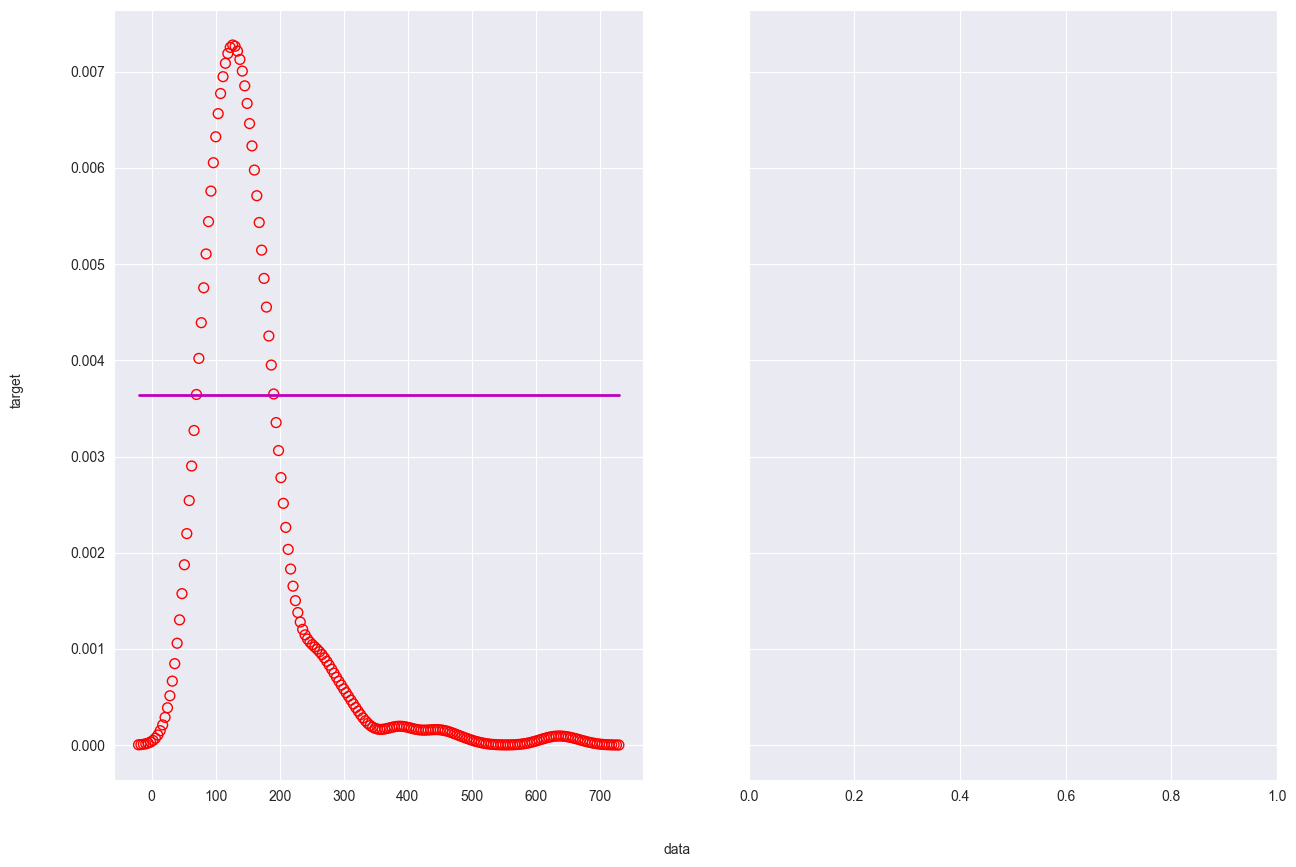

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10), sharey='all')
for ix, svr in enumerate(svrs):
    axes[ix].plot(
        x,
        svr.fit(x, y).predict(x),
        color=model_color[ix],
        lw=lw,
        label="{} model".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        x[svr.support_],
        y[svr.support_],
        facecolor="none",
        edgecolor=model_color[ix],
        s=50,
        label="{} support vectors".format(kernel_label[ix]),
    )
    axes[ix].scatter(
        x[np.setdiff1d(np.arange(len(x)), svr.support_)],
        y[np.setdiff1d(np.arange(len(x)), svr.support_)],
        facecolor="none",
        edgecolor="r",
        s=50,
        label="other training data",
    )

fig.text(0.5, 0.04, "data", ha="center", va="center")
fig.text(0.06, 0.5, "target", ha="center", va="center", rotation="vertical")
plt.show()

In [12]:
# Non-linear regression second approach
x_data, y_data = (listings_numeric["HORSEPOWER"].values, listings_numeric["HORSEPOWER"].values)
c = Counter(listings_numeric["HORSEPOWER"])

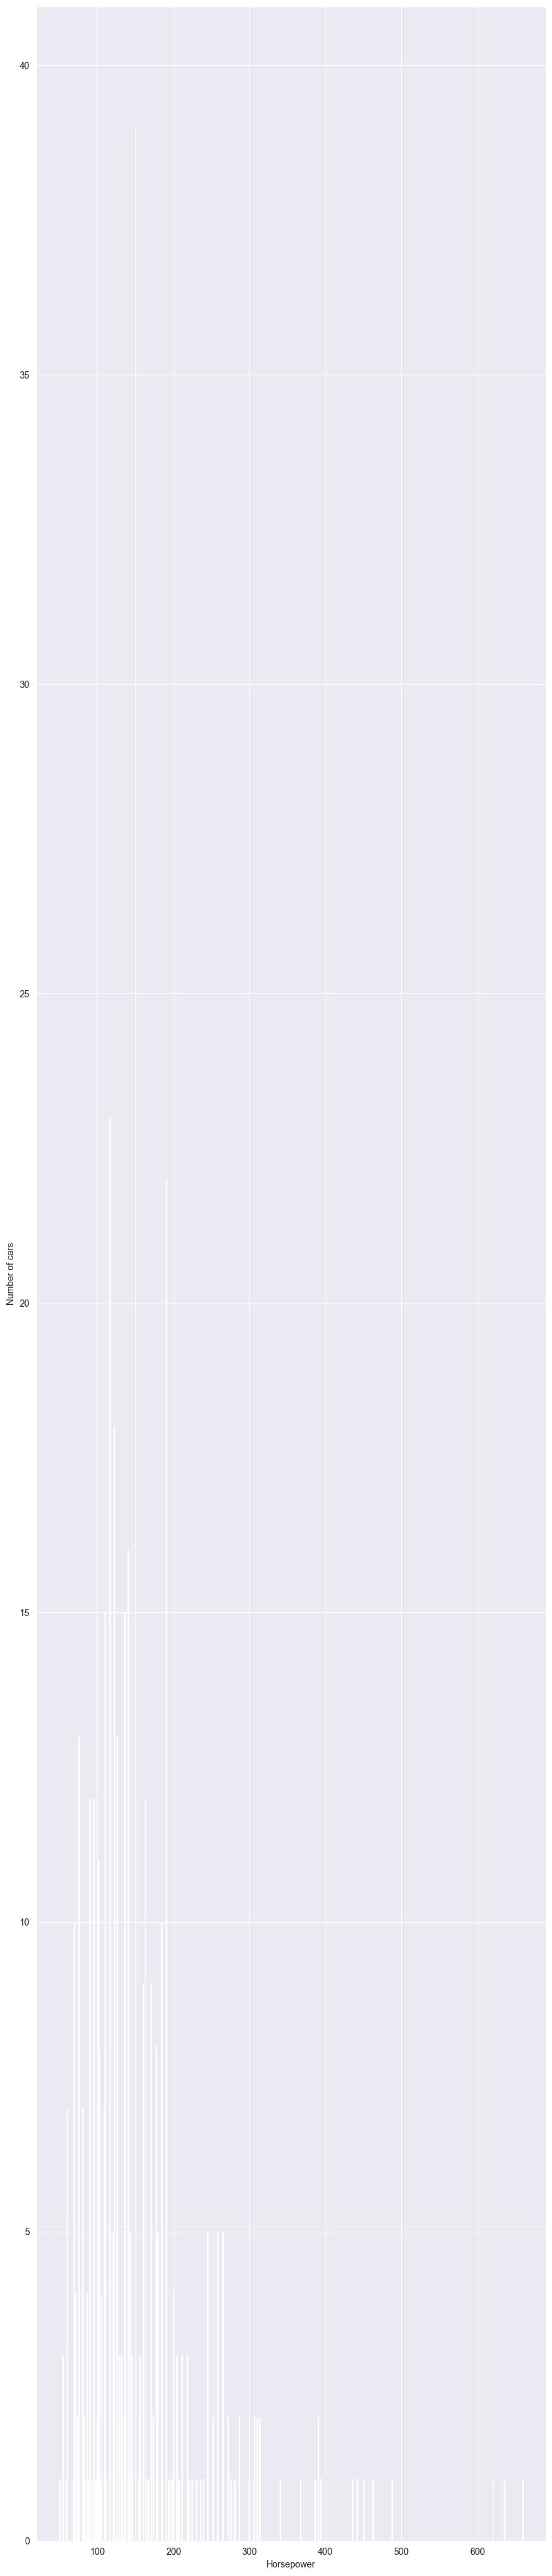

<Figure size 640x480 with 0 Axes>

In [13]:
plt.figure(figsize=(10,50))
#plt.plot(x_data, y_data, 'ro')
plt.bar(c.keys(), c.values())
plt.ylabel('Number of cars')
plt.xlabel('Horsepower')
plt.show()
plt.tight_layout()

In [14]:
x_data, y_data = c.keys(), c.values()

In [15]:
def sigmoid(x, Beta_1, Beta_2):
    for i in range(int(Beta_2)):
        y = 1 / (1 + np.exp(-Beta_1*(x-Beta_2)))
    return y
beta1 = 0.10
beta2 = 1990.0
#logistic function
Y_pred = sigmoid(x_data, beta1 , beta2)

plt.plot(x_data, Y_pred*15000000000000.)
plt.plot(x_data, y_data, 'ro')

TypeError: 'float' object is not iterable